In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [11]:
train_data = pd.read_csv(RAW_PATH / 'train.csv', parse_dates=['date'])
train_data = train_data.set_index('date')

In [12]:
train_data.head()

,nextDayPlayerEngagement,games,rosters,playerBoxScores,teamBoxScores,transactions,standings,awards,events,playerTwitterFollowers,teamTwitterFollowers
date,,,,,,,,,,,
2018-01-01,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe...","[{""date"":""2018-01-01"",""teamId"":147,""teamName"":..."
2018-01-02,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-03,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-04,"[{""engagementMetricsDate"":""2018-01-05"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-04"",""t...",NaN,NaN,"[{""transactionId"":339549,""playerId"":545343,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-05,"[{""engagementMetricsDate"":""2018-01-06"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-05"",""t...",NaN,NaN,"[{""transactionId"":341195,""playerId"":628336,""pl...",NaN,NaN,NaN,NaN,NaN


### time and player data 

In [13]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [14]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [15]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

### target 

In [16]:
from data.ingest_data import ingest_target, ingest_features
from data.util import filter_by_date, filter_by_id

In [17]:
%time target = ingest_target(train_data)

preprocessing target
CPU times: user 17.3 s, sys: 262 ms, total: 17.6 s
Wall time: 17.6 s


In [18]:
target.head()

,playerId,target1,target2,target3,target4,date,target_avg
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389


In [19]:
df = target.copy()

In [20]:
df = filter_by_id(df, player_in_test)

In [21]:
playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()

In [22]:
playerList

,playerId,target_avg
0,547180,18.775985
1,660271,18.055585
2,545361,17.410036
3,605141,17.236386
4,592450,16.850044
...,...,...
1182,593590,0.119988
1183,656458,0.115664
1184,676424,0.094298
1185,641927,0.086976


In [23]:
# df = filter_by_id(df, playerList['playerId'].head(10))

In [24]:
df.playerId.nunique()

1187

In [25]:
# player stats

In [26]:
train_data.columns

Index(['nextDayPlayerEngagement', 'games', 'rosters', 'playerBoxScores',
       'teamBoxScores', 'transactions', 'standings', 'awards', 'events',
       'playerTwitterFollowers', 'teamTwitterFollowers'],
      dtype='object')

In [27]:
df = ingest_features(df, train_data)

In [28]:
# del train_data

### preprocessing 

In [29]:
from typing import List
def forward_fill(df: pd.DataFrame, features: List[str],
                 on='playerId',
                 limit: int =None):
    ffilled_df = df.groupby(on)[features].ffill(limit=limit)
    df.loc[:, features] = ffilled_df
    return df

In [30]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    df['rostersTime'] = (df['date'] - pd.to_datetime(df['rosterDate'])).dt.total_seconds()
    df['rostersTime'] /= 60 * 60 * 24
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    df['AwardWinner'] = df['awardId'].isna().astype(np.float32)
    return df

In [31]:
def fillna(df: pd.DataFrame, fill_value=-1):
    return df.fillna(-1)

In [32]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info

In [33]:
# transformer for joining data and create base features
fill_forward_tmf = FunctionTransformer(forward_fill, kw_args={'features':['numberOfFollowers',
                                                                        'teamFollowers',
                                                                        'status',
                                                                        'teamId', 'rosterDate']})
join_season_tmf = FunctionTransformer(join_season_info,
                                      kw_args={'path_to_season': RAW_PATH / 'seasons.csv',
                                             'date_attr': ['year', 'month']})
join_players_tmf = FunctionTransformer(join_players_info, kw_args={'path_to_players': RAW_PATH / 'players.csv'})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [34]:
# creating pipeline
join_and_compute_feat_pl = Pipeline([('season', join_season_tmf),
                                     ('players', join_players_tmf),
                                     ('fill_forward', fill_forward_tmf),
                                     ('hardcoded_feat', harcoded_feat_tmf)])

In [35]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [36]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year',
              'primaryPositionName', 'month', 'status', 'teamId', 'awardId']

categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [37]:
# target statistics

stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'],
                             windows=[90],
                             drop_index=True)
stats_lagger_tmf = LagGen(lags=[1, 60], drop_index=False)

# create mean and median stats after lagging the target 1 day
stats_lagger_tmf = Pipeline([('lags', stats_lagger_tmf),
                             ('stats', stats_gen_tmf),
                             ('fillnan', FunctionTransformer(fillna)),
                             ('normalize', PdScaleNorm())])

# last 11 days as features
lagger_tmf = Pipeline([('lags', LagGen(lags=[1])),
                       ('fillnan', FunctionTransformer(fillna)),
                       ('normalize', PdScaleNorm())])


target_stats_tmf = PdColumnTransformer([
    ('lags_stats', stats_lagger_tmf, pp_cols),
    ('lags', lagger_tmf, pp_cols)
                                  ])

In [38]:
# continuous preprocessing

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

# get the rest of the continuous features
continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures()),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [39]:
# putting all together
all_features_tmf = PdFeatureUnion([('target_stats', target_stats_tmf), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ('cats', categories_tmf)
                                  ])

In [40]:
# main pipeline with all steps 
pipeline = Pipeline([('join_compute', join_and_compute_feat_pl),
                    ('features_gen', all_features_tmf)])

In [41]:
from data.split import *

In [42]:
sp = SplitData("2021-03-01", test_days=61)

In [43]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [44]:
%%time
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 2min 1s, sys: 33.9 s, total: 2min 35s
Wall time: 3min 2s


Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7f1ebd3b33a0>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7f1ebd3b34c0>,
                                                      kw_args={'path_to_players': PosixPath('data/raw/playe...
                                                                                     ('seasonPart',
                                                                                      Categorify(add_nan=True),
                                                   

In [45]:
%%time
features = pipeline.transform(df)

CPU times: user 32.8 s, sys: 2.12 s, total: 34.9 s
Wall time: 35.2 s


In [46]:
pd.options.display.max_rows = 100
features.T

,0,1,2,3,4,5,6,7,8,9,...,1443382,1443383,1443384,1443385,1443386,1443387,1443388,1443389,1443390,1443391
target1__1lag__mean__90d,0.0,0.011405,0.011328,0.011065,0.010834,0.010959,0.010826,0.010719,0.010636,0.010575,...,0.014701,0.014728,0.014740,0.014745,0.014752,0.014761,0.014766,0.014768,0.014769,0.014772
target1__1lag__median__90d,0.0,0.011405,0.011328,0.011252,0.010895,0.011252,0.010895,0.010539,0.010349,0.010160,...,0.009947,0.009959,0.009968,0.009975,0.009986,0.009996,0.010007,0.010021,0.010029,0.010032
target1__1lag__std__90d,0.0,0.000000,0.014141,0.014640,0.014830,0.014818,0.014862,0.014881,0.014879,0.014861,...,0.039648,0.039640,0.039636,0.039634,0.039632,0.039629,0.039627,0.039626,0.039626,0.039625
target2__1lag__mean__90d,0.0,0.222271,0.170436,0.147374,0.138181,0.121029,0.117314,0.157410,0.168022,0.162968,...,0.083101,0.083237,0.083292,0.083590,0.085297,0.085326,0.085406,0.085479,0.085908,0.089355
target2__1lag__median__90d,0.0,0.222271,0.170436,0.118600,0.114602,0.110604,0.105927,0.110604,0.114602,0.118600,...,0.053724,0.053724,0.053724,0.053724,0.053948,0.053948,0.053948,0.053948,0.053948,0.054093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
primaryPositionName,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
month,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
status,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
teamId,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000


In [47]:
time_dp_features = ['battingOrder', 'gamesPlayedBatting', 'flyOuts', 'groundOuts',
       'runsScored', 'doubles', 'triples', 'homeRuns', 'strikeOuts',
       'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch', 'atBats',
       'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

In [48]:
all_features = features.columns

In [49]:
import re
def filter_by_pattern(features: List[str], pattern: str):
    return [f for f in features
            if re.search(pattern, f) is not None]

In [50]:
# re.search('^target(.*?)\d*lag$', 'target4__60lag__median__90d')

In [51]:
one_lag_features = filter_by_pattern(all_features, '^target(.*?)\d*lag$')

In [52]:
one_lag_features = filter_by_pattern(all_features, '^target(.*?)\d*lag$')

In [53]:
one_lag_moving_stats = filter_by_pattern(all_features,
                                         '^target\d__1lag(.*?)\d*d$')

In [54]:
one_lag_moving_stats

['target1__1lag__mean__90d',
 'target1__1lag__median__90d',
 'target1__1lag__std__90d',
 'target2__1lag__mean__90d',
 'target2__1lag__median__90d',
 'target2__1lag__std__90d',
 'target3__1lag__mean__90d',
 'target3__1lag__median__90d',
 'target3__1lag__std__90d',
 'target4__1lag__mean__90d',
 'target4__1lag__median__90d',
 'target4__1lag__std__90d']

In [55]:
real_data_moving_stats = filter_by_pattern(all_features,
                                         '^target\d__60lag(.*?)\d*d$')

In [56]:
real_data_moving_stats

['target1__60lag__mean__90d',
 'target1__60lag__median__90d',
 'target1__60lag__std__90d',
 'target2__60lag__mean__90d',
 'target2__60lag__median__90d',
 'target2__60lag__std__90d',
 'target3__60lag__mean__90d',
 'target3__60lag__median__90d',
 'target3__60lag__std__90d',
 'target4__60lag__mean__90d',
 'target4__60lag__median__90d',
 'target4__60lag__std__90d']

In [57]:
static_features = list(all_features.drop((one_lag_features +
                                         one_lag_moving_stats +
                                         real_data_moving_stats + 
                                         categories + time_dp_features)))

In [58]:
static_features

['numberOfFollowers',
 'teamFollowers',
 'weight',
 'height',
 'playerBMI',
 'playerAge',
 'playerTSinceDebut',
 'playerDebutAge',
 'rostersTime']

In [59]:
df[target_cols] = df[target_cols].astype(np.float32)

In [60]:
train_data = sp.filter(features, train_idx)
raw_train_df = sp.filter(df, train_idx)

In [61]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [62]:
train_data.shape, raw_valid_df.shape


((1370985, 118), (72407, 86))

In [63]:
valid_data.shape, raw_train_df.shape

((72407, 118), (1370985, 86))

In [64]:
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [65]:
from omegaconf import OmegaConf
hp = {'bptt': 7,
      'epochs': 5,
      'batch_size': 512,
      'max_emb_sz': 20,
      'hidden_dim': 10,
      'encoder_dim': 50,
      'emb_dropout': 0.05,
      'dropout': 0.05,
      'lr': 0.01,
      'wd': 0.}

real_data_config = {'hp': hp,
                    'seed': 2021,
         'static_features': static_features+real_data_moving_stats,
          'categories': categories,
          'time_features': time_dp_features,
          'target_cols': target_cols}
real_data_config = OmegaConf.create(real_data_config) 

In [66]:
from train.lstm import run_lstm

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [67]:
real_data_lstm_output = run_lstm(real_data_config, train_data, valid_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 29.8 K
1 | net          | LSTM           | 3.4 K 
2 | output_layer | Sequential     | 5.7 K 
------------------------------------------------
38.8 K    Trainable params
0         Non-trainable params
38.8 K    Total params
0.155     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers`

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [68]:
hp = {'bptt': 7,
      'epochs': 5,
      'batch_size': 512,
      'max_emb_sz': 20,
      'hidden_dim': 10,
      'encoder_dim': 50,
      'emb_dropout': 0.05,
      'dropout': 0.05,
      'lr': 0.01,
      'wd': 0.}

onelag_data_config = {'hp': hp,
                    'seed': 2021,
                     'static_features': static_features,
                      'categories': categories,
                      'time_features': time_dp_features + one_lag_features,
                      'target_cols': target_cols}
onelag_data_config = OmegaConf.create(onelag_data_config)

In [69]:
lag_data_lstm_output = run_lstm(onelag_data_config, train_data, valid_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 29.8 K
1 | net          | LSTM           | 3.6 K 
2 | output_layer | Sequential     | 5.1 K 
------------------------------------------------
38.4 K    Trainable params
0         Non-trainable params
38.4 K    Total params
0.154     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [70]:
from train.lgbm import run_lgbm

In [71]:
lgbm_parameters = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}
lgbm_config = {'hp': lgbm_parameters,
          'features': (categories +
                       static_features +
                       real_data_moving_stats +
                       time_dp_features),
          'categories': categories,
          'target_cols': target_cols}
lgbm_config = OmegaConf.create(lgbm_config)

lgbm_config

{'hp': {'objective': 'mae', 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'n_estimators': 100000, 'learning_rate': 0.1, 'random_state': 42}, 'features': ['playerId', 'seasonPart', 'year', 'primaryPositionName', 'month', 'status', 'teamId', 'awardId', 'numberOfFollowers', 'teamFollowers', 'weight', 'height', 'playerBMI', 'playerAge', 'playerTSinceDebut', 'playerDebutAge', 'rostersTime', 'target1__60lag__mean__90d', 'target1__60lag__median__90d', 'target1__60lag__std__90d', 'target2__60lag__mean__90d', 'target2__60lag__median__90d', 'target2__60lag__std__90d', 'target3__60lag__mean__90d', 'target3__60lag__median__90d', 'target3__60lag__std__90d', 'target4__60lag__mean__90d', 'target4__60lag__median__90d', 'target4__60lag__std__90d', 'battingOrder', 'gamesPlayedBatting', 'flyOuts', 'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns', 'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch', 'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay', 'groundIntoTriplePl

In [72]:
lgbm_output = run_lgbm(lgbm_config, train_data, valid_data)

target1


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['awardId', 'month', 'playerId', 'primaryPositionName', 'seasonPart', 'status', 'teamId', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.38496
[200]	valid_0's l1: 1.38176
[300]	valid_0's l1: 1.38059
[400]	valid_0's l1: 1.37892
[500]	valid_0's l1: 1.37813
[600]	valid_0's l1: 1.377
[700]	valid_0's l1: 1.37564
[800]	valid_0's l1: 1.37549
Early stopping, best iteration is:
[766]	valid_0's l1: 1.37531
target2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 2.99339
[200]	valid_0's l1: 2.98764
Early stopping, best iteration is:
[181]	valid_0's l1: 2.9862
target3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.23391
[200]	valid_0's l1: 1.23562
Early stopping, best iteration is:
[115]	valid_0's l1: 1.23387
target4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.82544
[200]	valid_0's l1: 1.81523
[300]	valid_0's l1: 1.81465
[400]	valid_0's l1: 1.81078
[500]	valid_0's l1: 1.80984
Early stopping, best iteration is:
[476]	valid_0's l1: 1.80971


In [73]:
from train.core import predict_recursive, Ensemble
ensemble = Ensemble([real_data_lstm_output, lag_data_lstm_output, lgbm_output],
                    pipeline)

In [74]:
%%time
raw_train_fr = raw_train_df[df.columns].copy()

recursive_prediction = []
for date, val_date_df in raw_valid_df.groupby('date'):
    val_date_df = val_date_df[df.columns].reset_index(drop=True)
    _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
                                                     raw_train_fr,
                                                     ensemble,
                                                     n_days=90 + 60 + 10,
                                                     target_cols=target_cols)
    recursive_prediction.append(_recurive_pred)

recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
recursive_prediction.reset_index(drop=True, inplace=True)
recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
                                     for f in target_cols}, inplace=True)
recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

    target1    target2   target3    target4       date  playerId
0  1.930292  26.078324  0.674135  26.623548 2021-03-01    405395
1  0.526395  16.782778  0.398548  11.457988 2021-03-01    408234
2  0.015540   1.789014  0.020197   0.919354 2021-03-01    424144
3  0.021856   2.014736  0.016285   0.573983 2021-03-01    425772
4  0.003926   0.874514  0.003118   0.282188 2021-03-01    425784
    target1    target2   target3    target4       date  playerId
0  0.932472  22.961701  0.375410  19.783556 2021-03-02    405395
1  0.420313  16.963801  0.273120   9.191792 2021-03-02    408234
2  0.015147   1.806602  0.020038   0.875386 2021-03-02    424144
3  0.022907   1.865943  0.016248   0.548894 2021-03-02    425772
4  0.004460   0.945053  0.003379   0.289329 2021-03-02    425784
    target1    target2   target3    target4       date  playerId
0  0.820358  22.175150  0.350901  17.577545 2021-03-03    405395
1  0.383879  16.821198  0.250108   8.896845 2021-03-03    408234
2  0.014328   1.838382  0

    target1    target2   target3    target4       date  playerId
0  0.674397  19.394278  0.303046  14.735913 2021-03-23    405395
1  0.360224  17.125144  0.236633   8.478603 2021-03-23    408234
2  0.013630   1.792050  0.018317   0.811922 2021-03-23    424144
3  0.016312   1.529489  0.014010   0.467879 2021-03-23    425772
4  0.004365   0.985513  0.003223   0.285930 2021-03-23    425784
    target1    target2   target3    target4       date  playerId
0  0.674643  19.392650  0.303113  14.745297 2021-03-24    405395
1  0.360286  17.128728  0.236653   8.479915 2021-03-24    408234
2  0.013737   1.790518  0.018317   0.812073 2021-03-24    424144
3  0.016302   1.528119  0.014011   0.468025 2021-03-24    425772
4  0.004357   0.985316  0.003222   0.285936 2021-03-24    425784
    target1    target2   target3    target4       date  playerId
0  0.674996  19.396716  0.303271  14.752653 2021-03-25    405395
1  0.360331  17.131534  0.236665   8.480715 2021-03-25    408234
2  0.013722   1.940566  0

    target1    target2   target3    target4       date  playerId
0  1.315164  19.181626  0.827487  19.713841 2021-04-13    405395
1  0.130544   4.482461  0.479581   9.351826 2021-04-13    408234
2  0.011672   1.063029  0.014820   0.951312 2021-04-13    424144
3  0.002079   0.060329  0.004743   0.303104 2021-04-13    425772
4  0.001017   0.042841  0.001658   0.199703 2021-04-13    425784
    target1    target2   target3    target4       date  playerId
0  0.924363  17.305974  0.684168  19.531731 2021-04-14    405395
1  0.112155   3.981190  0.458497   9.012369 2021-04-14    408234
2  0.032497   1.267294  0.018323   0.992816 2021-04-14    424144
3  0.002034   0.056713  0.004719   0.304064 2021-04-14    425772
4  0.001008   0.041978  0.001656   0.199155 2021-04-14    425784
    target1    target2   target3    target4       date  playerId
0  0.673527  16.802393  0.610131  18.549229 2021-04-15    405395
1  0.103215   3.796688  0.450903   8.822726 2021-04-15    408234
2  0.013796   0.989754  0

with best 500 ids 
one day lag

{'mae_mean': 15.404842,
 'mae_1': 15.112363,
 'mae_2': 12.518346,
 'mae_3': 15.941521,
 'mae_4': 18.04714}
 
{'mae_mean': 16.107979,
 'mae_1': 14.4299965,
 'mae_2': 13.712786,
 'mae_3': 17.216927,
 'mae_4': 19.072205}
 
lag 60 day 150 stats mean median std
raw_valid_df

{'mae_mean': 16.526415,
 'mae_1': 15.134252,
 'mae_2': 15.736391,
 'mae_3': 16.731949,
 'mae_4': 18.503065}
 
{'mae_mean': 16.243195,
 'mae_1': 14.64544,
 'mae_2': 15.223519,
 'mae_3': 16.67205,
 'mae_4': 18.43177}
 
 
with best 500 ids 
one day lag 
{'mae_mean': 2.4375365,
 'mae_1': 2.2795138,
 'mae_2': 3.1164076,
 'mae_3': 1.6708878,
 'mae_4': 2.6833365}
 
{'mae_mean': 3.2938020082107333,
 'mae_1': 2.5740078375938165,
 'mae_2': 5.631358953836824,
 'mae_3': 1.837284798457624,
 'mae_4': 3.1325564429546677}
 
lag 60 day 150 stats mean median std

{'mae_mean': 2.8213322,
 'mae_1': 2.4738746,
 'mae_2': 3.9536836,
 'mae_3': 1.8413752,
 'mae_4': 3.0163958}
 
{'mae_mean': 2.8054446768310446,
 'mae_1': 2.4669433853402922,
 'mae_2': 3.901420425393473,
 'mae_3': 1.8396196560640896,
 'mae_4': 3.0137952405263246}
 
 con toda la data
 
 {'mae_mean': 1.5619345,
 'mae_1': 1.2107118,
 'mae_2': 2.4501314,
 'mae_3': 0.95569867,
 'mae_4': 1.6311963}
 
 
 {'mae_mean': 1.5390999144452775,
 'mae_1': 1.210369386168515,
 'mae_2': 2.3818660584590656,
 'mae_3': 0.9496059085908733,
 'mae_4': 1.6145583045626561}
 

In [75]:
from evaluate.metrics import compute_metrics

In [76]:
# /
prediction = (real_data_lstm_output.prediction + lag_data_lstm_output.prediction) / 2

# prediction = real_data_lstm_output.prediction

valid_test_prediction = pd.DataFrame(prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]

is_test_pred = valid_test_prediction['date'] >= '2021-04-01'

valid_prediction, test_prediction = (valid_test_prediction.loc[~is_test_pred, :],
                                     valid_test_prediction.loc[is_test_pred, :])

valid_rc_prediction, test_rc_prediction = (recursive_prediction.loc[~is_test_pred, :],
                                           recursive_prediction.loc[is_test_pred, :])

In [77]:
compute_metrics(valid_prediction)

{'mae_mean': 1.95931,
 'mae_1': 1.3433183,
 'mae_2': 3.3341556,
 'mae_3': 1.370043,
 'mae_4': 1.7897236}

In [78]:
compute_metrics(valid_rc_prediction)

{'mae_mean': 2.170508030031909,
 'mae_1': 1.5120687118039229,
 'mae_2': 3.5319654384419246,
 'mae_3': 1.4996813396801363,
 'mae_4': 2.138316630201652}

In [79]:
compute_metrics(test_prediction)

{'mae_mean': 1.4076967,
 'mae_1': 1.1479342,
 'mae_2': 2.089181,
 'mae_3': 0.907911,
 'mae_4': 1.4857605}

In [80]:
compute_metrics(test_rc_prediction)

{'mae_mean': 1.4969911122881683,
 'mae_1': 1.1886618318886801,
 'mae_2': 2.257760285409005,
 'mae_3': 0.94162282501754,
 'mae_4': 1.5999195068374477}

In [81]:
compute_metrics(valid_test_prediction)

{'mae_mean': 1.6880249,
 'mae_1': 1.2472277,
 'mae_2': 2.721873,
 'mae_3': 1.142765,
 'mae_4': 1.6402336}

In [82]:
compute_metrics(recursive_prediction)

{'mae_mean': 1.839270201633348,
 'mae_1': 1.3530161479111804,
 'mae_2': 2.9053071664585217,
 'mae_3': 1.225226332469023,
 'mae_4': 1.873531159694666}

In [87]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

In [92]:
(valid_test_prediction.groupby('playerId')
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,20.850380,17.664379,23.899216,22.812458,19.025469
665487,17.701075,17.982599,9.140873,21.252253,22.428576
545361,14.830729,11.647164,11.760548,10.833225,25.081980
596019,14.382043,15.857469,11.747024,13.313926,16.609753
594798,13.308234,9.395679,16.747967,11.249312,15.839978
...,...,...,...,...,...
547001,0.073665,0.000245,0.262360,0.000114,0.031940
669212,0.065460,0.001512,0.218303,0.000699,0.041327
665733,0.053645,0.002610,0.145240,0.004759,0.061969


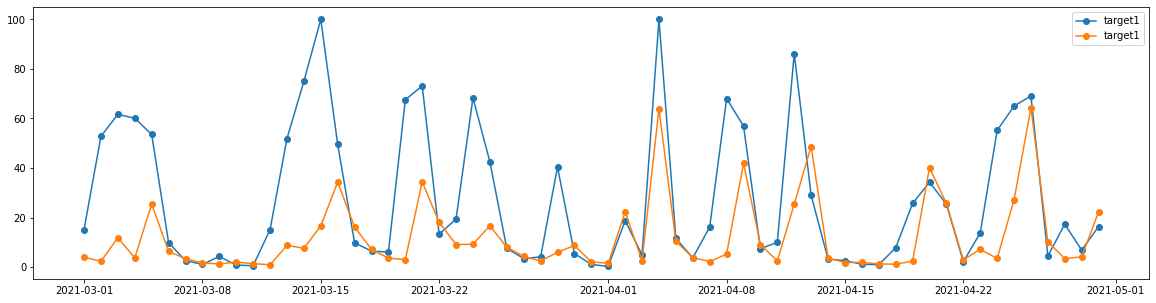

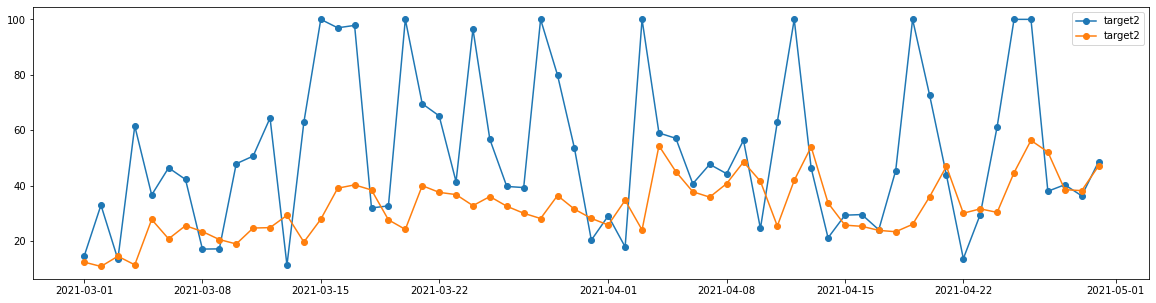

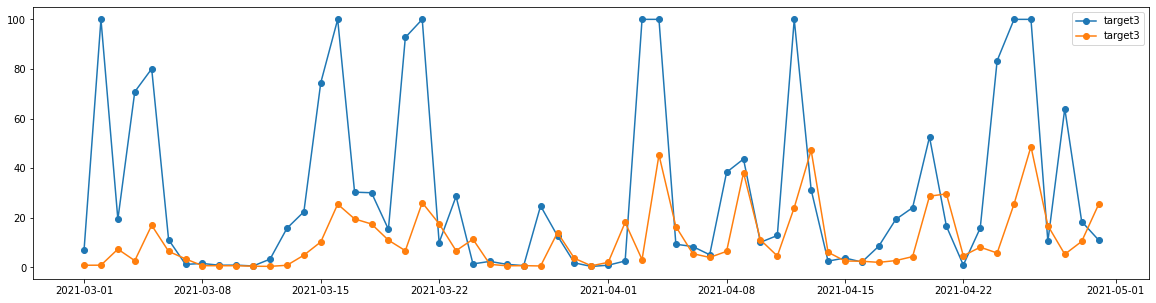

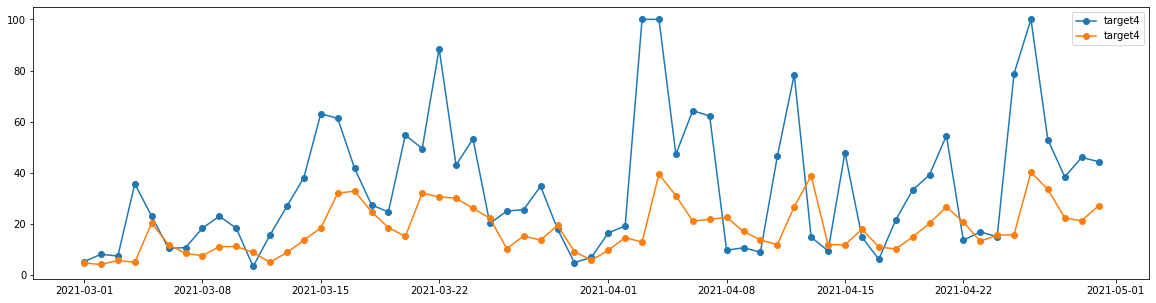

In [89]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

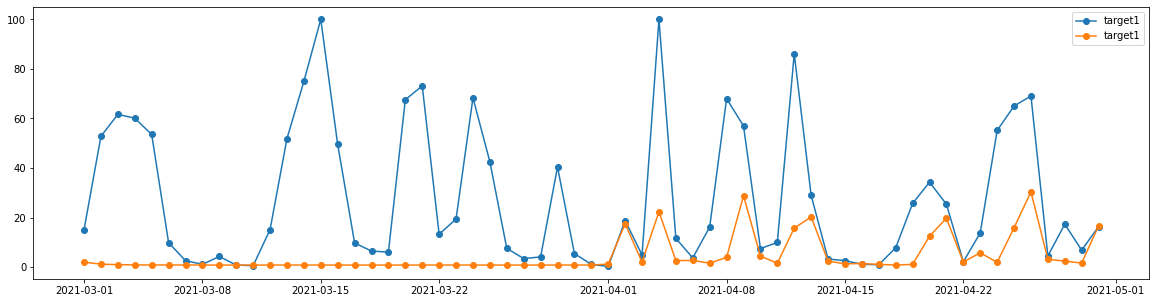

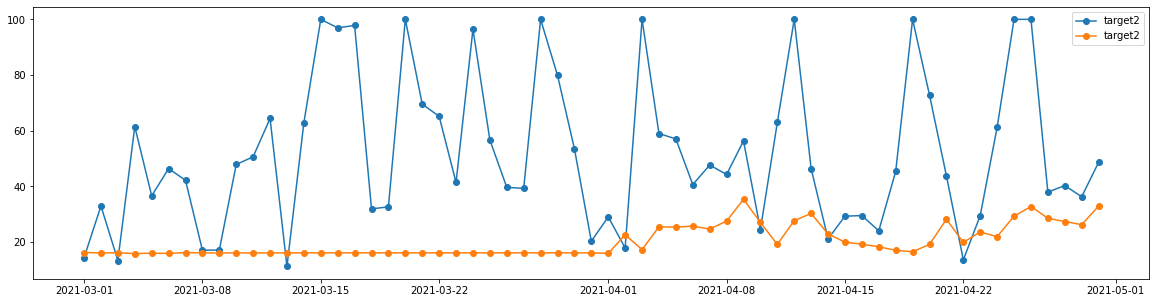

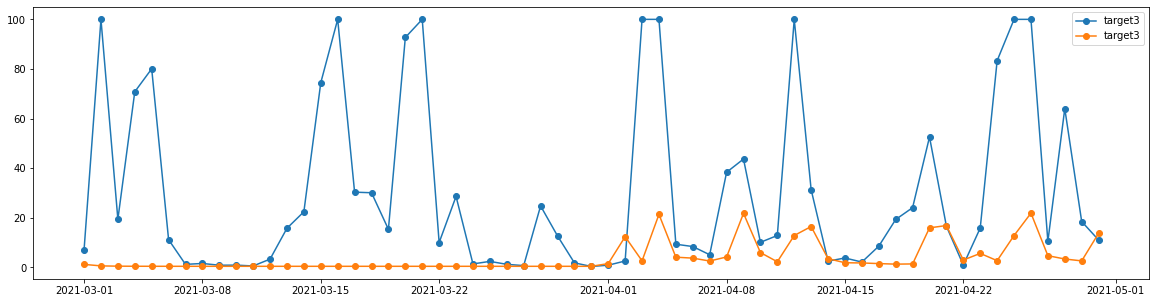

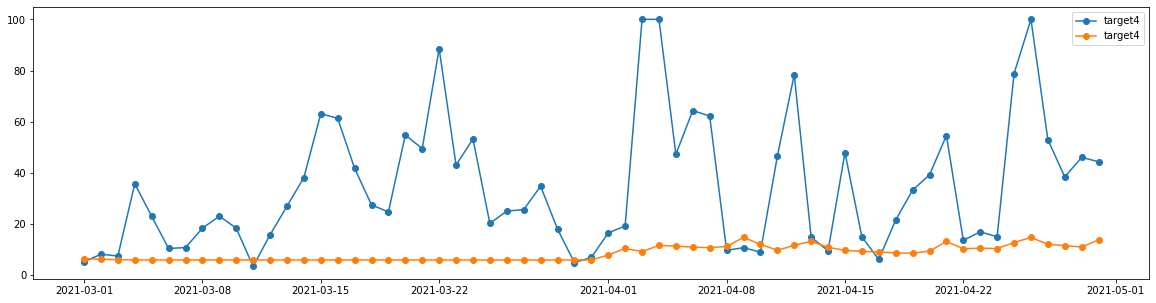

In [90]:
for index in range(1, 5):
    plot_pred(recursive_prediction, playerId=660271, index=index)